In [42]:
import torch
import torch.nn.functional as F
from torch import nn , optim

from torchvision import transforms , models

from PIL import Image
import matplotlib.pyplot as plt

import requests
from io import BytesIO

import copy

**Select device as per the availibility of GPU(cuda)**

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Defining the constants

In [44]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 10000
ITERATIONS = 500

### Loading and preparing the images

In [45]:
# Function that can open both web and local hosted images
def get_img(path):
    if path.startswith('http'):
        return Image.open(BytesIO(requests.get(path).content))
    else:
        return Image.open(path)
    
content_img_path = 'https://cdn.britannica.com/86/170586-050-AB7FEFAE/Taj-Mahal-Agra-India.jpg';
style_img_path = 'https://cdn.shopify.com/s/files/1/1227/0270/products/Van_Gogh_-_Starry_Night-11000px.jpg?v=1627762556'

content_img = get_img(content_img_path)
content_img = content_img.resize((IMG_WIDTH, IMG_HEIGHT))

style_img = get_img(style_img_path);
style_img = style_img.resize((IMG_WIDTH, IMG_HEIGHT))

# To transform images and convert them into 
def to_tensor(img):
    loader = transforms.Compose([transforms.ToTensor()])
    img = loader(img).unsqueeze(0)
    return img.to(device, torch.float)

content_img = to_tensor(content_img)
style_img = to_tensor(style_img)

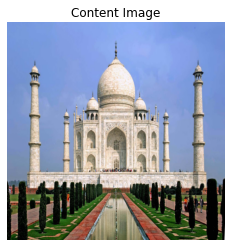

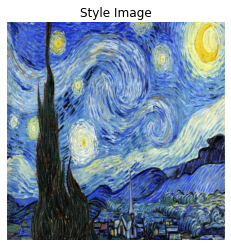

In [46]:
# To convert tensors to actual images
def to_img(tensor):
    img = tensor.cpu().clone()
    img = img.squeeze(0)
    img = transforms.ToPILImage()(img)
    
    return img

def show_tensor_img(tensor, title=None): 
    img = to_img(tensor)
    plt.figure()
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.imshow(img)
    
show_tensor_img(content_img, 'Content Image')
show_tensor_img(style_img, 'Style Image')

### Content and Style Losses

For the content loss, we are using Mean Squared Loss. We add the content loss module after certain convolution layers to compute the MSE between the activation.

In [47]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

For the style loss, we need to do some extra work. We want to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the output image.

To do this we calculate the **Gram-matrix** or the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.

Finally we also need to normalize the matrix to counteract the fact that the feature mps with large N dimensions give larger values in the Gram Matrix.

In [48]:
def gram_matrix(input):
    a, b, c, d = input.size() 
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

After this the style loss is very similar to content loss. The style distance is also calculated using MSE.

In [49]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

We are using the VGG model. VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

In [50]:
# Module to normalize input images before sending to the NN. 
# Recieves the standard values of the VGG model and normalizes the values in input.
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Downloading the VGG model

In [51]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

### Building the new network

Here we build the new network by keeping only certin layers of the VGG19 model and add in between the feature and content loss.

In [52]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Layers for we will use for the content and style extraction
content_layers = ['conv_1', 'conv_2', 'conv_4']
style_layers = ['conv_2', 'conv_3', 'conv_4', 'conv_7', 'conv_10', 'conv_8']

def get_model_and_losses(style_img, content_img,
                               cnn=cnn,
                               cnn_normalization_mean=cnn_normalization_mean,
                               cnn_normalization_std=cnn_normalization_std):
    
  # Copy the cnn to not affect the original one
  cnn = copy.deepcopy(cnn)
  
  # Normalization module
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

  # To store losses computed by the network.
  content_losses = []
  style_losses = []

  # To rebuild the new nn model from ground up
  model = nn.Sequential(normalization)

  # Incremented every time we see a conv layer.
  i = 0  
  for layer in cnn.children():

    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    # Check if the layer we just added was in the content layer list.
    # If so, we just stack a Content Loss layer.
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    # Check if the layer we just added was in the style layer list.
    # If so, we just stack a Style Loss layer.
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # Now we trim off the layers after the last content and style losses
  # Only keep whats necessary 
  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

<Figure size 432x288 with 0 Axes>

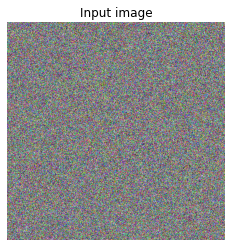

In [53]:
# Setting up the input image
input_img = torch.randn(content_img.data.size(), device=device)


plt.figure()
show_tensor_img(input_img, 'Input image')

In [54]:
# Optimizer for the gradient descent
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

### Executing the Style Transfer

Here we perform the actual style transfer. For each iteration, we use updated input and computes new losses for the content and style. 

Building the style transfer model..
Optimizing..


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


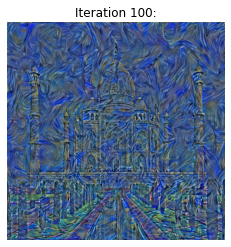

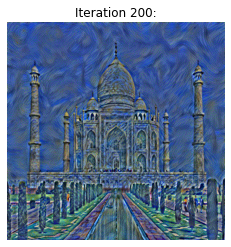

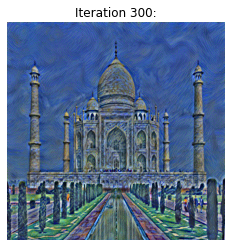

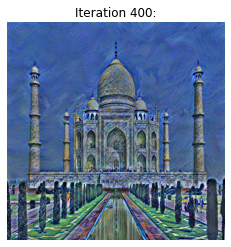

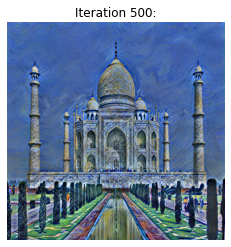

In [55]:
print('Building the style transfer model..')
model, style_losses, content_losses = get_model_and_losses(style_img, content_img)

input_img.requires_grad_(True)
model.requires_grad_(False)

optimizer = get_input_optimizer(input_img)

print('Optimizing..')
iterations = 0

while iterations <= ITERATIONS:
    def closure():
        global iterations
        
        with torch.no_grad():
            input_img.clamp_(0, 1)
        
        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0
        
        for sc in style_losses:
            style_score += sc.loss
            
        for cs in content_losses:
            content_score += cs.loss
        
        style_score *= STYLE_WEIGHT
        content_score *= CONTENT_WEIGHT
        
        loss = style_score + content_score
        
        iterations += 1
        if iterations % 100 == 0:
            show_tensor_img(input_img.data.clone().detach().clamp(0, 1), title="Iteration %d:" % iterations)
        
        loss.backward()
        return loss
        
    optimizer.step(closure)

with torch.no_grad():
    input_img.clamp_(0, 1)

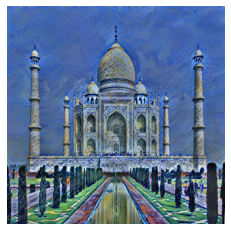

In [56]:
img = to_img(input_img)
plt.figure()
plt.axis('off')
plt.imshow(img)
plt.savefig('output')